# データ読み込み

In [261]:
from sklearn.datasets import load_iris
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris_data = load_iris()
X = iris_data.data
Y = iris_data.target
data_names = ['sepal_length','sepal_width','petal_length','petal_width']
target_names = ['setosa', 'versicolor', 'virginica']
#print(type(X))
# print(type(target_names))

df_X = pd.DataFrame(X,columns = data_names)
df_Y = pd.DataFrame(Y,columns = ['Species'])

X = df_X.values
X = X[0:100]
X = X[:,[2,3]]
print(X.shape)

Y = df_Y.values
Y = Y[0:100]
Y = np.where(Y>0,1,-1)
print(Y.shape)

X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.25, random_state=0)

(100, 2)
(100, 1)


# 【問題1】不純度を求める関数

ノード の ジニ不純度 を計算する関数を作成してください。
<br>
ノード t に対するジニ不純度I(t)は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。
$$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$$


t
 : ノードのインデックス

i
 : クラスのインデックス

K
 : クラスの数

C
i
 : i番目のクラス

P
(
C
i
|
t
)
 :　t番目のノードにおける
C
i
の割合

N
t
,
i
 : t番目のノードのi番目のクラスに属するサンプル数

N
t
,
a
l
l
 : t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較してください。

In [254]:
# 初期閾値
np.random.seed(1)
lam = np.random.uniform(np.min(X),np.max(X) , (2, 1))
# print(lam)


def gini_impurity(X,Y):
    left = np.zeros(3)
    right = np.zeros(3)
    Y_l = np.sum(Y > 0)
    Y_r = np.sum(Y < 0)
    for i in range(X.shape[0]):
        if X[i,0] > 1:#lam[1]:
            left[0] += 1
            if Y[i] == 1:
                left[1] += 1
            else:
                left[2] += 1
        else:
            right[0] += 1
            if Y[i] == 1:
                right[1] += 1
            else:
                right[2] += 1
                
    gini_a = 1 - ((Y_l/Y.shape[0])**2 + (Y_r/Y.shape[0])**2)
    gini_l = 1 - ((left[1]/left[0])**2 + (left[2]/left[0])**2)
    gini_r = 1 - ((right[1]/right[0])**2 + (right[2]/right[0])**2)
    
#     print(left[0])
#     print(left[1])
#     print(left[2])
#     print(right[0])
#     print(right[1])
#     print(right[2]) 
#     print(Y_l)
#     print(Y_r)     

    return gini_a, gini_l, gini_r, left, right

print(gini_impurity(X,Y))
# ig_p = gini_impurity(X,Y)[0]
# ig_l = gini_impurity(X,Y)[1]
# ig_r = gini_impurity(X,Y)[2]
# left = gini_impurity(X,Y)[3]
# right = gini_impurity(X,Y)[4]

# print(ig_l)

(0.5, 0.49994898479746963, 0.0, array([99., 50., 49.]), array([1., 0., 1.]))


# 【問題2】情報利得を求める関数

次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

In [255]:
def information_profit(ig_p,ip_l,ig_r,left,right,Y):
    ig = ig_p - left[0]/Y.shape[0]*ig_l\
        - right[0]/Y.shape[0]*ig_r
#     print(ig_p)
#     print(left[0])
#     print(ig_l)
#     print(right[0])
#     print(ig_r)
    return ig
information_profit(ig_p,ig_l,ig_r,left,right,Y)

0.005050505050505083

# 【問題3】学習

空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

《組み合わせの取り方》

全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。

他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

《補足》

問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

In [258]:
def information_profit_full(X,Y,lam):
    left = np.zeros(3)
    right = np.zeros(3)
    Y_l = np.sum(Y > 0)
    Y_r = np.sum(Y < 0)
    for i in range(X.shape[0]):
        if X[i,0] >= lam[0]:
            left[0] += 1
            if Y[i] == 1:
                left[1] += 1
            else:
                left[2] += 1
        else:
            right[0] += 1
            if Y[i] == 1:
                right[1] += 1
            else:
                right[2] += 1
                
    gini_a = 1 - ((Y_l/Y.shape[0])**2 + (Y_r/Y.shape[0])**2)
    gini_l = 1 - ((left[1]/left[0])**2 + (left[2]/left[0])**2)
    gini_r = 1 - ((right[1]/right[0])**2 + (right[2]/right[0])**2)
    ig = gini_a - left[0]/Y.shape[0]*gini_l\
        - right[0]/Y.shape[0]*gini_r
#     print(ig_p)
#     print(left[0])
#     print(ig_l)
#     print(right[0])
#     print(ig_r)
    return ig
# print(lam)
print(information_profit_full(X,Y,[[4],[0]]))

0.319672131147541


In [259]:
lam = np.zeros(2)
ig = np.zeros(X.shape[0])
for k in range(X.shape[0]):
    lam[0] = X[k,0]
#     lam = lam + 0.01
    ig[k] = information_profit_full(X,Y,lam)

# print(ig)
ig_max_ind = np.argmax(ig)
print(ig_max_ind)
print(ig)
print(lam[0])
# print(ig[ig_max_ind])#分割基準
# print(lam)
# print(X[ig_max_ind,0])

22
[0.06179775 0.06179775 0.02083333 0.15789474 0.06179775 0.39285714
 0.06179775 0.15789474 0.06179775 0.15789474 0.15789474 0.29365079
 0.06179775 0.00505051 0.01020408 0.15789474 0.02083333 0.06179775
 0.39285714 0.15789474 0.39285714 0.15789474        nan 0.39285714
 0.46153846 0.29365079 0.29365079 0.15789474 0.06179775 0.29365079
 0.29365079 0.15789474 0.15789474 0.06179775 0.15789474 0.01020408
 0.02083333 0.06179775 0.02083333 0.15789474 0.02083333 0.02083333
 0.02083333 0.29365079 0.46153846 0.06179775 0.29365079 0.06179775
 0.15789474 0.06179775 0.06179775 0.13291139 0.02083333 0.31967213
 0.08139535 0.13291139 0.06179775 0.48039216 0.08139535 0.36206897
 0.44339623 0.22463768 0.31967213 0.06179775 0.40909091 0.16666667
 0.13291139 0.25757576 0.13291139 0.36206897 0.03191489 0.31967213
 0.02083333 0.06179775 0.18493151 0.16666667 0.03191489 0.01020408
 0.13291139 0.44339623 0.37719298 0.39285714 0.36206897 0.00505051
 0.13291139 0.13291139 0.06179775 0.16666667 0.25757576 0.3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


# 【問題4】推定

In [243]:
class ScratchDecesionTreeClassifierDepth1():
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.ig_list = []
        self.verbose = verbose
    def fit(self, X, Y):
        self.X = X[X[:,0].argsort(), :]
        self.Y = Y
        lam = np.zeros(self.X.shape[1])
        ig = np.zeros(self.X.shape[0] - 1)
        self.ig = ig
        for k in range(self.X.shape[0] - 1):
            lam[0] = self.X[k,0]
            self._information_profit_full(lam)

        self.ig_max_ind = np.argmax(self.ig_list)
        self.ig_max = np.max(self.ig_list)
        
    def _information_profit_full(self,lam):
        left = np.zeros(3)
        right = np.zeros(3)
        Y_l = np.sum(Y > 0)
        Y_r = np.sum(Y < 0)
        for i in range(self.X.shape[0]):
            if self.X[i,0] > lam[0]:
                left[0] += 1
                if self.Y[i] == 1:
                    left[1] += 1
                else:
                    left[2] += 1
            else:
                right[0] += 1
                if self.Y[i] == 1:
                    right[1] += 1
                else:
                    right[2] += 1

        gini_a = 1 - ((Y_l/self.Y.shape[0])**2 + (Y_r/self.Y.shape[0])**2)
        gini_l = 1 - ((left[1]/left[0])**2 + (left[2]/left[0])**2)
        gini_r = 1 - ((right[1]/right[0])**2 + (right[2]/right[0])**2)
        ig = gini_a - left[0]/self.Y.shape[0]*gini_l\
            - right[0]/self.Y.shape[0]*gini_r
        self.ig_list.append(ig)
    #     print(ig_p)
    #     print(left[0])
    #     print(ig_l)
    #     print(right[0])
    #     print(ig_r)
        return
        
#         if self.verbose:
#             #verboseをTrueにした際は学習過程を出力
#             print()
        pass
    def predict(self, X):
        y_pred =  np.zeros(X.shape[0])
#         print(self.X[self.ig_max_ind,0])
        for i in range(X.shape[0]):
            if X[i,0] >= self.X[self.ig_max_ind,0]: 
                y_pred[i] = 1
#                 print(y_pred[i])
            else:
                y_pred[i] = -1
        print(y_pred)
        self.y_perd = y_pred
        return self.y_perd

In [245]:
clf = ScratchDecesionTreeClassifierDepth1()
clf.fit(X, Y)
y_p = clf.predict(X)

# # print(y_p)

# # X[22,1]

# clf.X
# print(clf.ig_max_ind)
# print(clf.ig_max)
# # print()
# print(clf.ig[clf.ig_max_ind])
# print(clf.X[clf.ig_max_ind])


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [250]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import itertools

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),\
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i],\
                    label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i])
for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [247]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(75, 2)
(25, 2)
(75, 1)
(25, 1)


[-1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.
 -1. -1. -1.  1. -1.  1. -1.]
[-1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.
  1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  1. -1.  1.]
(75, 1)
(75,)
(25, 1)
(25,)
学習結果0.9866666666666667
解析結果0.96
[-1. -1. -1. ...  1.  1.  1.]


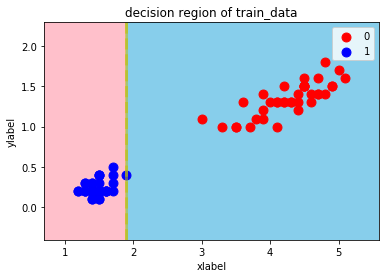

[-1. -1. -1. ...  1.  1.  1.]


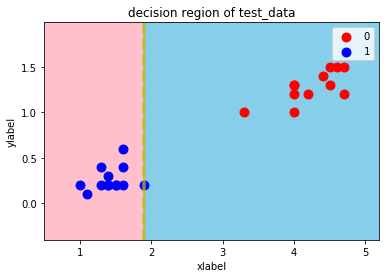

In [251]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf2 = ScratchDecesionTreeClassifierDepth1()
clf2.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)
y_pred_train1 = clf.predict(X_train)
print(y_train.shape)
print(y_pred_train1.T.shape)
print(y_test.shape)
print(y_pred1.T.shape)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
print("学習結果" + str(metrics.accuracy_score(y_train, y_pred_train1.T)))
print("解析結果" + str(metrics.accuracy_score(y_test, y_pred1.T)))
decision_region(X_train,list(itertools.chain.from_iterable(y_train)),clf,\
                title='decision region of train_data')
decision_region(X_test,list(itertools.chain.from_iterable(y_test)),clf,\
                title='decision region of test_data')

In [275]:
class ScratchDecesionTreeClassifierDepth2():
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.ig_list = []
        self.verbose = verbose
    def fit(self, X, Y):
        self.X = X[X[:,0].argsort(), :]
        self.Y = Y
        lam = np.zeros(self.X.shape[1])
        ig = np.zeros(self.X.shape[0] - 1)
        self.ig = ig
        for k in range(self.X.shape[0] - 1):
            lam[0] = self.X[k,0]
            self._information_profit_full(lam)

        self.ig_max_ind = np.argmax(self.ig_list)
        self.ig_max = np.max(self.ig_list)
        
    def _information_profit_full(self,lam):
        left = np.zeros(3)
        right = np.zeros(3)
        Y_l = np.sum(Y > 0)
        Y_r = np.sum(Y < 0)
        for i in range(self.X.shape[0]):
            if self.X[i,0] > lam[0]:
                left[0] += 1
                if self.Y[i] == 1:
                    left[1] += 1
                else:
                    left[2] += 1
            else:
                right[0] += 1
                if self.Y[i] == 1:
                    right[1] += 1
                else:
                    right[2] += 1

        gini_a = 1 - ((Y_l/self.Y.shape[0])**2 + (Y_r/self.Y.shape[0])**2)
        gini_l = 1 - ((left[1]/left[0])**2 + (left[2]/left[0])**2)
        gini_r = 1 - ((right[1]/right[0])**2 + (right[2]/right[0])**2)
        ig = gini_a - left[0]/self.Y.shape[0]*gini_l\
            - right[0]/self.Y.shape[0]*gini_r
        self.ig_list.append(ig)
    #     print(ig_p)
    #     print(left[0])
    #     print(ig_l)
    #     print(right[0])
    #     print(ig_r)
        return
        
#         if self.verbose:
#             #verboseをTrueにした際は学習過程を出力
#             print()
        pass
    def predict(self, X):
        y_pred =  np.zeros(X.shape[0])
#         print(self.X[self.ig_max_ind,0])
        for i in range(X.shape[0]):
            if X[i,0] >= self.X[self.ig_max_ind,0]: 
                y_pred[i] = 1
#                 print(y_pred[i])
            else:
                y_pred[i] = -1
        print(y_pred)
        self.y_perd = y_pred
        return self.y_perd

# シンプルデータ２

In [280]:
Xs2 = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
ys2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xs2, ys2, test_size=0.25, random_state=1)

y_train2 = y_train2.reshape(30,1)
y_test2 = y_test2.reshape(10,1)

print(y_train2.shape)
print(y_test2.shape)

(30, 1)
(10, 1)


# 【問題5】学習と推定

機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。
<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。
<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

# 【問題6】決定領域の可視化

決定領域を可視化してください。

[ 1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
[ 1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.]
[ 1.  1. -1.  1. -1.  1.  1.  1. -1. -1.]
(30, 1)
(30,)
(10, 1)
(10,)
学習結果0.2
解析結果0.5
[-1. -1. -1. ...  1.  1.  1.]


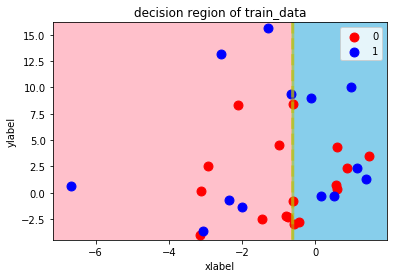

[-1. -1. -1. ...  1.  1.  1.]


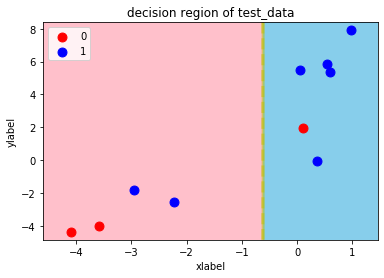

In [281]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf3 = ScratchDecesionTreeClassifierDepth2()
clf3.fit(X_train2, y_train2)
y_pred1_s2 = clf3.predict(X_test2)
y_pred_train1_s2 = clf3.predict(X_train2)
print(y_pred1_s2)
print(y_train2.shape)
print(y_pred_train1_s2.T.shape)
print(y_test2.shape)
print(y_pred1_s2.T.shape)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
print("学習結果" + str(metrics.accuracy_score(y_train2, y_pred_train1_s2.T)))
print("解析結果" + str(metrics.accuracy_score(y_test2, y_pred1_s2.T)))
decision_region(X_train2,list(itertools.chain.from_iterable(y_train2)),clf3,\
                title='decision region of train_data')
decision_region(X_test2,list(itertools.chain.from_iterable(y_test2)),clf3,\
                title='decision region of test_data')

In [284]:
class ScratchDecesionTreeClassifierDepth3():
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.ig_list = []
        self.verbose = verbose
    def fit(self, X, Y):
        self.X = X[X[:,1].argsort(), :]
        self.Y = Y
        lam = np.zeros(self.X.shape[1])
        ig = np.zeros(self.X.shape[0] - 1)
        self.ig = ig
        for k in range(self.X.shape[0] - 1):
            lam[1] = self.X[k,1]
            self._information_profit_full(lam)

        self.ig_max_ind = np.argmax(self.ig_list)
        self.ig_max = np.max(self.ig_list)
        
    def _information_profit_full(self,lam):
        left = np.zeros(3)
        right = np.zeros(3)
        Y_l = np.sum(Y > 0)
        Y_r = np.sum(Y < 0)
        for i in range(self.X.shape[0]):
            if self.X[i,1] > lam[1]:
                left[0] += 1
                if self.Y[i] == 1:
                    left[1] += 1
                else:
                    left[2] += 1
            else:
                right[0] += 1
                if self.Y[i] == 1:
                    right[1] += 1
                else:
                    right[2] += 1

        gini_a = 1 - ((Y_l/self.Y.shape[0])**2 + (Y_r/self.Y.shape[0])**2)
        gini_l = 1 - ((left[1]/left[0])**2 + (left[2]/left[0])**2)
        gini_r = 1 - ((right[1]/right[0])**2 + (right[2]/right[0])**2)
        ig = gini_a - left[0]/self.Y.shape[0]*gini_l\
            - right[0]/self.Y.shape[0]*gini_r
        self.ig_list.append(ig)
    #     print(ig_p)
    #     print(left[0])
    #     print(ig_l)
    #     print(right[0])
    #     print(ig_r)
        return
        
#         if self.verbose:
#             #verboseをTrueにした際は学習過程を出力
#             print()
        pass
    def predict(self, X):
        y_pred =  np.zeros(X.shape[0])
#         print(self.X[self.ig_max_ind,0])
        for i in range(X.shape[0]):
            if X[i,1] >= self.X[self.ig_max_ind,0]: 
                y_pred[i] = 1
#                 print(y_pred[i])
            else:
                y_pred[i] = -1
        print(y_pred)
        self.y_perd = y_pred
        return self.y_perd

[ 1.  1. -1. -1. -1.  1.  1.  1. -1. -1.]
[-1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.
  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.]
[ 1.  1. -1. -1. -1.  1.  1.  1. -1. -1.]
(30, 1)
(30,)
(10, 1)
(10,)
学習結果0.26666666666666666
解析結果0.4
[-1. -1. -1. ...  1.  1.  1.]


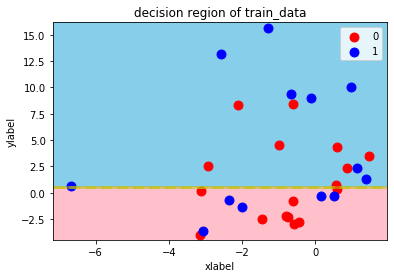

[-1. -1. -1. ...  1.  1.  1.]


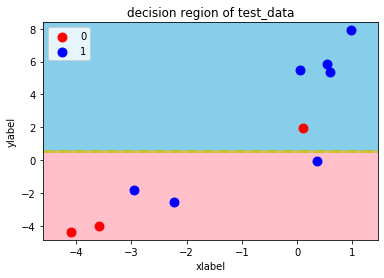

In [285]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf4 = ScratchDecesionTreeClassifierDepth3()
clf4.fit(X_train2, y_train2)
y_pred1_s2 = clf4.predict(X_test2)
y_pred_train1_s2 = clf4.predict(X_train2)
print(y_pred1_s2)
print(y_train2.shape)
print(y_pred_train1_s2.T.shape)
print(y_test2.shape)
print(y_pred1_s2.T.shape)

# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
print("学習結果" + str(metrics.accuracy_score(y_train2, y_pred_train1_s2.T)))
print("解析結果" + str(metrics.accuracy_score(y_test2, y_pred1_s2.T)))
decision_region(X_train2,list(itertools.chain.from_iterable(y_train2)),clf4,\
                title='decision region of train_data')
decision_region(X_test2,list(itertools.chain.from_iterable(y_test2)),clf4,\
                title='decision region of test_data')